In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import deque
import matplotlib.pyplot as plt
import torchvision
from tqdm.notebook import tqdm

In [2]:
from dataset_utils import gain_dataset

In [3]:
(
    train_single_data,
    train_multi_data,
    test_data,
    train_single_label,
    train_multi_label,
    test_label,
) = gain_dataset("./tmp_data", "shapes")

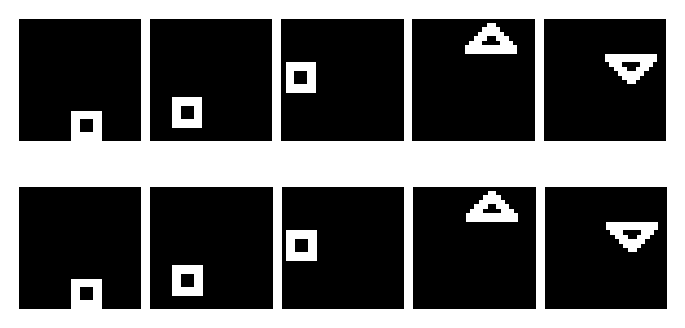

In [4]:
# train_single_data
fig, axes = plt.subplots(2, 1, figsize=(20, 4))

ax = axes[0]
img = torchvision.utils.make_grid(
    torch.as_tensor(train_single_data)[:5].unsqueeze(1), nrow=5, pad_value=1
)
ax.imshow(img.permute(1, 2, 0))
# remove frame
ax.axis("off")

ax = axes[1]
img = torchvision.utils.make_grid(
    torch.as_tensor(train_single_label)[:5].unsqueeze(1), nrow=5, pad_value=1
)
ax.imshow(img.permute(1, 2, 0))
# remove frame
ax.axis("off")

plt.show()

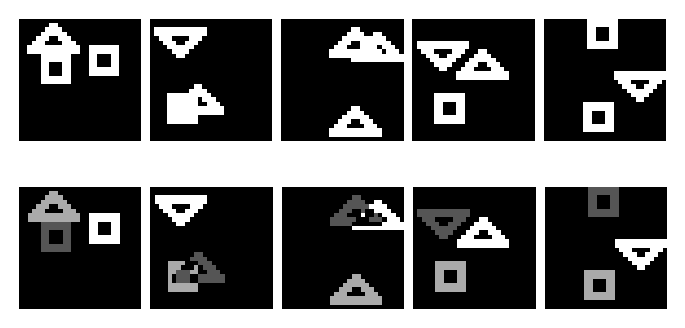

In [5]:
# train_multi_data
fig, axes = plt.subplots(2, 1, figsize=(20, 4))

ax = axes[0]
img = torchvision.utils.make_grid(
    torch.as_tensor(train_multi_data)[:5].unsqueeze(1), nrow=5, pad_value=1
)
ax.imshow(img.permute(1, 2, 0))
# remove frame
ax.axis("off")

ax = axes[1]
img = torchvision.utils.make_grid(
    torch.as_tensor(train_multi_label).div(3)[:5].unsqueeze(1), nrow=5, pad_value=1
)
ax.imshow(img.permute(1, 2, 0))
# remove frame
ax.axis("off")

plt.show()

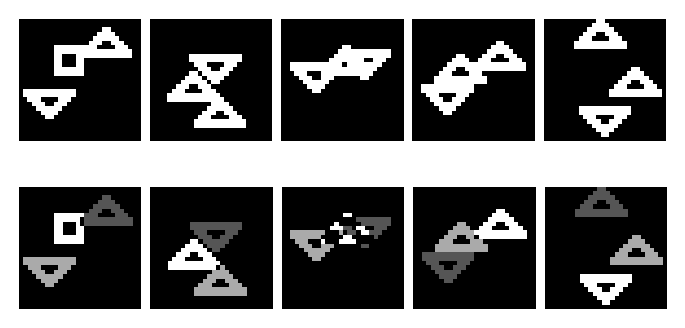

In [6]:
# train_multi_data
fig, axes = plt.subplots(2, 1, figsize=(20, 4))

ax = axes[0]
img = torchvision.utils.make_grid(
    torch.as_tensor(test_data)[:5].unsqueeze(1), nrow=5, pad_value=1
)
ax.imshow(img.permute(1, 2, 0))
# remove frame
ax.axis("off")

ax = axes[1]
img = torchvision.utils.make_grid(
    torch.as_tensor(test_label).div(3)[:5].unsqueeze(1), nrow=5, pad_value=1
)
ax.imshow(img.permute(1, 2, 0))
# remove frame
ax.axis("off")

plt.show()

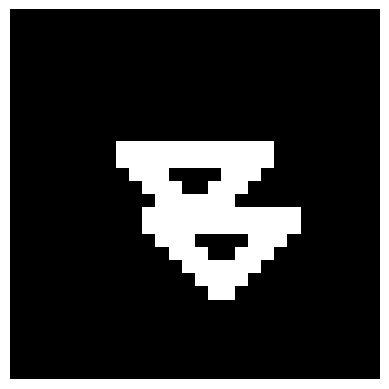

In [7]:
square = torch.tensor(
    [
        [1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 0, 0, 1, 1],
        [1, 1, 0, 0, 0, 1, 1],
        [1, 1, 0, 0, 0, 1, 1],
        [1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1],
    ]
)

triangle = torch.tensor(
    [
        [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0],
        [0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0],
        [0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0],
        [0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    ]
)

shapes = [square, triangle, triangle.flip(dims=(0,)).clone()]
class_names = ["square", "triangle", "inverted-triangle"]


def generate_shapes_image(width, height, nr_shapes=2):
    img = torch.zeros(height, width)
    cluster = torch.zeros(nr_shapes, height, width)
    target = torch.randint(0, len(shapes), (nr_shapes,))

    for i in range(nr_shapes):
        shape_idx = target[i]
        shape = shapes[shape_idx]
        sy, sx = shape.shape
        x = torch.randint(0, width - sx + 1, ())
        y = torch.randint(0, height - sy + 1, ())
        region = (slice(y, y + sy), slice(x, x + sx))
        img[region] += shape
        cluster[i][region] += shape

    img = img.clamp_max_(1)
    return img, cluster, target


plt.imshow(generate_shapes_image(28, 28, 2)[0], cmap="gray")
plt.axis("off")
plt.show()

In [8]:
def rand_context_like(tensor):
    return torch.randn_like(tensor).abs()


def random_mask_like(tensor, p):
    return torch.empty_like(tensor).bernoulli_(p)


def flatten(intput):
    return intput.view(intput.size(0), -1)

In [9]:
def match_any_loss(logits, targets):
    """
    Forces the network to predict any one (but only one) of the targets.
    It picks the class that is already most similar to the target.

    Args:
        logits: (N, C)
        targets: (N, n) where n is the number of targets per sample
    """
    with torch.no_grad():
        candidates = torch.gather(logits, dim=1, index=targets)
        indices = torch.argmax(candidates, dim=1, keepdim=True)
        most_likely = torch.gather(targets, dim=1, index=indices)
        most_likely.squeeze_(dim=1)

    return F.cross_entropy(logits, most_likely)

In [10]:
def match_cluster_loss(logits, clusters):
    with torch.no_grad():
        similarities = torch.bmm(
            logits.unsqueeze(1), clusters.transpose(-1, -2)
        ).squeeze(1)
        max_similar = torch.argmax(similarities, dim=1)
        targets = clusters[torch.arange(logits.size(0)), max_similar]

    # im = torchvision.utils.make_grid(
    #     [logits[0].detach().view(1, 28, 28), targets[0].detach().view(1, 28, 28)]
    # )
    # plt.imshow(im.permute(1, 2, 0), cmap="gray")

    return torch.pow(logits - targets, 2).sum()

In [11]:
class Model(nn.Module):
    def __init__(self, features: int, num_classes: int) -> None:
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(features, 512), 
            nn.ReLU(), 
            nn.Linear(512, 400), 
            nn.ReLU(),
        )

        self.decoder = nn.Sequential(
            nn.Linear(400, 512), 
            nn.ReLU(), 
            nn.Linear(512, features), 
            nn.Sigmoid(),
        )

        self.classify = nn.Linear(400, num_classes)

    def forward(self, inputs):
        encoded = self.encoder(inputs)
        decoded = self.decoder(encoded)
        logits = self.classify(encoded)
        return decoded, encoded, logits

In [12]:
W = 28
H = 28
data = [generate_shapes_image(W, H, 2) for _ in range(50000)]

In [21]:
model = Model(784, len(class_names))
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

batch_size = 128
cortical_delay = 8
iterations = 3
s_refractory = 4

dataloader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)

for epoch_idx in range(10):
    epoch_loss = 0

    for inputs, clusters, targets in tqdm(dataloader):
        s_queue = deque([torch.zeros_like(inputs) for _ in range(3)], maxlen=3)
        in_refactory = torch.zeros_like(inputs)
        context_queue = deque(
            [rand_context_like(inputs) for _ in range(cortical_delay)],
            maxlen=cortical_delay,
        )

        loss = 0

        for _ in range(iterations * cortical_delay):
            in_refactory -= 1

            context_input = context_queue.popleft()
            activity = inputs * context_input

            # maybe should also add some sort of dropout here
            refactory_mask = (in_refactory < 0).float()

            activity = activity * refactory_mask
            # update refractory period for the neurons that spiked
            in_refactory[activity > 0.5] = s_refractory

            # accumulate all spikes over the last 3 time steps
            s_queue.append(activity)
            accumulate_input = torch.stack(tuple(s_queue), dim=0).sum(dim=0)
            # accumulate_input = inputs

            # feed the accumulated spikes to the denoising autoencoder
            # returns the denoised outputs and the latent variables
            output, encoding, logits = model(flatten(accumulate_input))

            for i in range(1, len(s_queue)):
                # randomly "forget" half of the spikes
                s_queue[i] *= random_mask_like(inputs, p=0.5)

            context_queue.append(output.view(inputs.shape))

            loss = loss + match_any_loss(logits, targets)
            loss = loss + match_cluster_loss(output, clusters.flatten(start_dim=-2)) / 1000

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    print(f"Epoch {epoch_idx} loss: {epoch_loss / len(dataloader)}")

  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 0 loss: 150.36079287711922


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 1 loss: 111.45987892638692


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2 loss: 95.73413958147054


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 3 loss: 87.51148098996838


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 4 loss: 78.05429789355344


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 5 loss: 70.83565665632868


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 6 loss: 65.66018131382936


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 7 loss: 61.455911192442755


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 8 loss: 58.657496557211324


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 9 loss: 56.061793266354925


tensor([1, 0, 2, 2, 1, 2, 1, 2, 2, 0])
tensor([[1, 2],
        [0, 1],
        [0, 1],
        [0, 1],
        [1, 0],
        [2, 1],
        [1, 1],
        [2, 2],
        [0, 2],
        [0, 0]])
tensor(0.8000)
tensor([1, 0, 2, 2, 1, 2, 1, 2, 2, 0])
tensor([[1, 2],
        [0, 1],
        [0, 1],
        [0, 1],
        [1, 0],
        [2, 1],
        [1, 1],
        [2, 2],
        [0, 2],
        [0, 0]])
tensor(0.8000)
tensor([1, 0, 1, 2, 1, 2, 1, 2, 2, 0])
tensor([[1, 2],
        [0, 1],
        [0, 1],
        [0, 1],
        [1, 0],
        [2, 1],
        [1, 1],
        [2, 2],
        [0, 2],
        [0, 0]])
tensor(0.9000)
tensor([0, 0, 2, 2, 1, 2, 2, 2, 0, 0])
tensor([[1, 2],
        [0, 1],
        [0, 1],
        [0, 1],
        [1, 0],
        [2, 1],
        [1, 1],
        [2, 2],
        [0, 2],
        [0, 0]])
tensor(0.6000)
tensor([0, 0, 1, 0, 2, 1, 2, 2, 0, 0])
tensor([[1, 2],
        [0, 1],
        [0, 1],
        [0, 1],
        [1, 0],
        [2, 1],
     

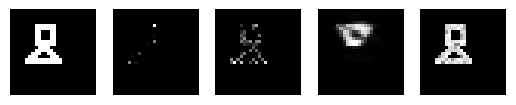

In [31]:
fig, axes = plt.subplots(1, 5)

test_data = [generate_shapes_image(W, H, 2) for _ in range(10)]
inputs = torch.stack([x[0] for x in test_data])
targets = torch.stack([x[2] for x in test_data])

s_queue = deque([torch.zeros_like(inputs) for _ in range(3)], maxlen=3)
in_refactory = torch.zeros_like(inputs)
context_queue = deque(
    [rand_context_like(inputs) for _ in range(cortical_delay)], maxlen=cortical_delay
)

for _ in range(cortical_delay):
    in_refactory -= 1

    context_input = context_queue.popleft()
    activity = inputs * context_input

    # maybe should also add some sort of dropout here
    refactory_mask = (in_refactory < 0).float()

    activity = activity * refactory_mask
    # update refractory period for the neurons that spiked
    in_refactory[activity > 0.5] = s_refractory

    # accumulate all spikes over the last 3 time steps
    s_queue.append(activity)
    accumulate_input = torch.stack(tuple(s_queue), dim=0).sum(dim=0)

    # feed the accumulated spikes to the denoising autoencoder
    # returns the denoised outputs and the latent variables
    output, encoding, logits = model(flatten(accumulate_input))

    for i in range(1, len(s_queue)):
        # randomly "forget" half of the spikes
        s_queue[i] *= random_mask_like(inputs, p=0.5)

    context_queue.append(output.view(inputs.shape))

    loss = loss + match_any_loss(logits, targets)

    pred = logits.argmax(dim=1)
    print(pred)
    print(targets)
    # 1 if pred is in targets on the 1st dimension
    print((pred.unsqueeze(1) == targets).any(dim=1).sum() / len(pred))

i = 3
axes[0].imshow(inputs[i].detach().numpy(), cmap="gray")
axes[1].imshow(activity[i].detach().numpy(), cmap="gray")
axes[2].imshow(accumulate_input[i].detach().numpy(), cmap="gray")
axes[3].imshow(output.view(inputs.shape)[i].detach().numpy(), cmap="gray")
axes[4].imshow(in_refactory[i].detach().numpy(), cmap="gray")
axes[0].axis("off")
axes[1].axis("off")
axes[2].axis("off")
axes[3].axis("off")
axes[4].axis("off")

plt.show()